Importing Libraries

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools
import tensorflow as tf
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

Data Ingestion

In [158]:
#importing the data
from google.colab import files
uploaded = files.upload()

Saving bitcoin_monthly_close.csv to bitcoin_monthly_close (4).csv


In [159]:
#reading in the data
data= pd.read_csv('bitcoin_monthly_close.csv')
data.head()

,Year_Month,Average_Close
0,2014-09,407.18
1,2014-10,364.15
2,2014-11,366.10
3,2014-12,341.27
4,2015-01,248.78


In [160]:
#checking data types
data.dtypes

,0
Year_Month,object
Average_Close,float64


In [161]:
#converting Year_Month column to datetime object and set as index
data['Year_Month']= pd.to_datetime(data['Year_Month'])
data.set_index('Year_Month', inplace=True)
data.head()

,Average_Close
Year_Month,
2014-09-01,407.18
2014-10-01,364.15
2014-11-01,366.10
2014-12-01,341.27
2015-01-01,248.78


Exploratory Data Analysis

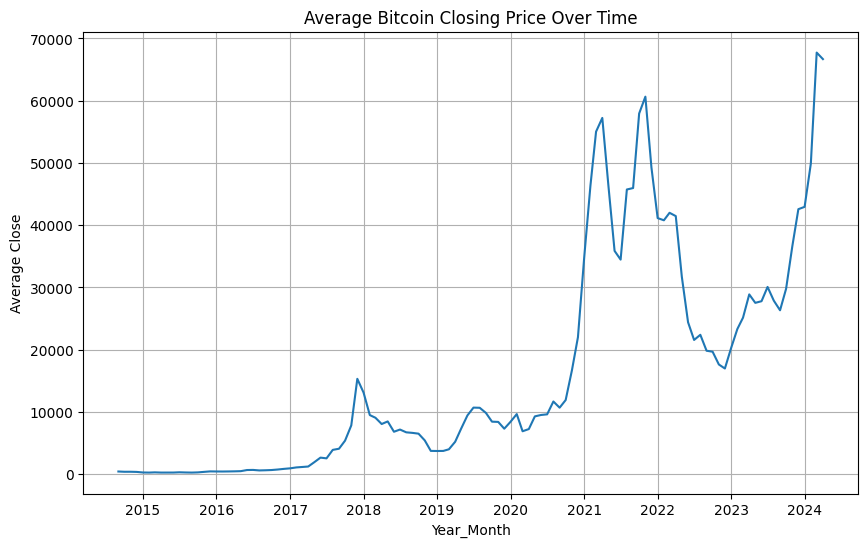

In [162]:
#line plot of Average_Close
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Average_Close'])
plt.xlabel('Year_Month')
plt.ylabel('Average Close')
plt.title('Average Bitcoin Closing Price Over Time')
plt.grid(True)
plt.show()

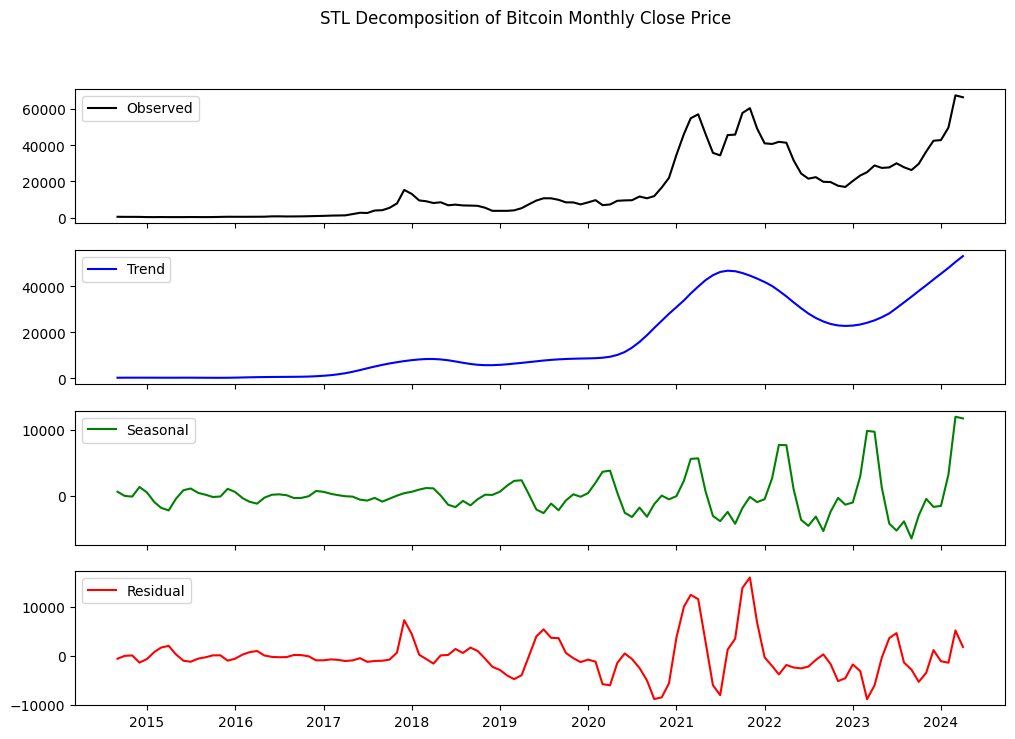

In [163]:
# Apply STL decomposition
stl = STL(data['Average_Close'], seasonal=13)  # 13-month seasonality to capture yearly pattern
result = stl.fit()

# Plot the STL decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axes[0].plot(data.index, data['Average_Close'], label='Observed', color='black')
axes[0].legend(loc='upper left')

axes[1].plot(data.index, result.trend, label='Trend', color='blue')
axes[1].legend(loc='upper left')

axes[2].plot(data.index, result.seasonal, label='Seasonal', color='green')
axes[2].legend(loc='upper left')

axes[3].plot(data.index, result.resid, label='Residual', color='red')
axes[3].legend(loc='upper left')

plt.suptitle('STL Decomposition of Bitcoin Monthly Close Price')
plt.show()

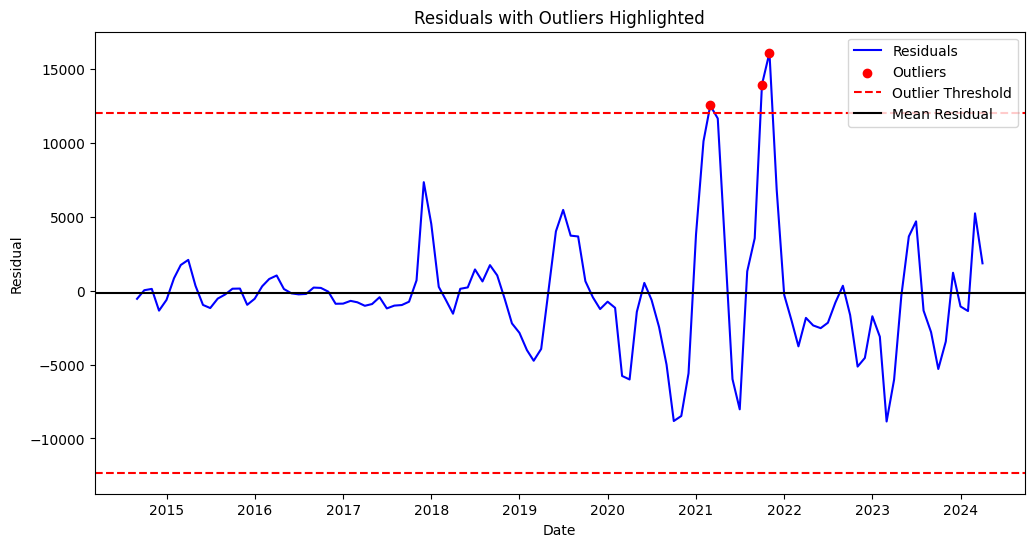

In [164]:
# Extract residuals
residuals = result.resid

# Calculate mean and standard deviation of residuals
mean_resid = np.mean(residuals)
std_resid = np.std(residuals)

# Define threshold for outliers (e.g., 3 standard deviations from the mean)
threshold = 3
outliers = residuals[(residuals > mean_resid + threshold * std_resid) | (residuals < mean_resid - threshold * std_resid)]

# Plot residuals and highlight outliers
plt.figure(figsize=(12, 6))
plt.plot(data.index, residuals, label='Residuals', color='blue')
plt.scatter(outliers.index, outliers, color='red', label='Outliers', zorder=3)
plt.axhline(mean_resid + threshold * std_resid, color='r', linestyle='dashed', label='Outlier Threshold')
plt.axhline(mean_resid - threshold * std_resid, color='r', linestyle='dashed')
plt.axhline(mean_resid, color='black', linestyle='solid', label='Mean Residual')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residuals with Outliers Highlighted')
plt.legend()
plt.show()

<Figure size 1200x500 with 0 Axes>

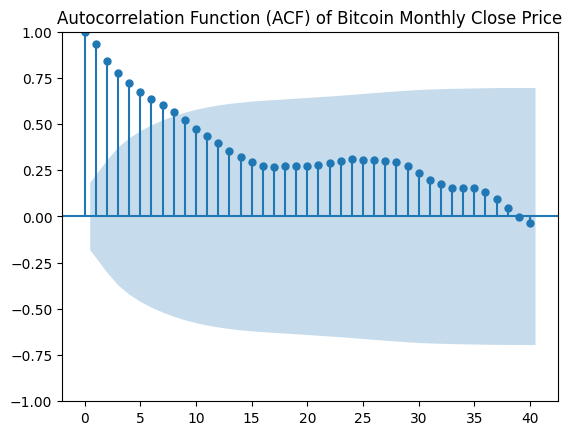

<Figure size 1200x500 with 0 Axes>

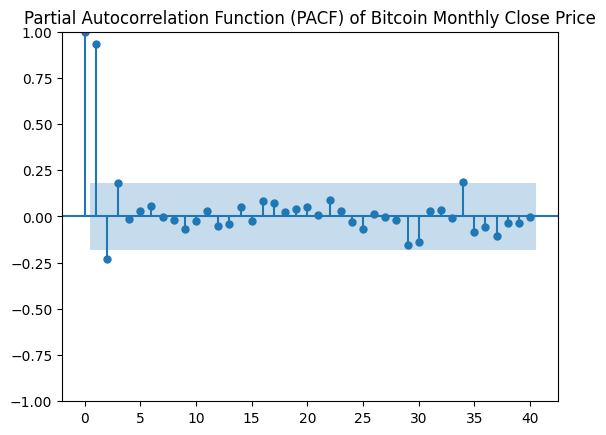

In [165]:
# Plot the ACF (Autocorrelation Function)
plt.figure(figsize=(12, 5))
plot_acf(data['Average_Close'], lags=40, alpha=0.05)  # Adjust lags as needed
plt.title("Autocorrelation Function (ACF) of Bitcoin Monthly Close Price")
plt.show()

# Plot the PACF (Partial Autocorrelation Function)
plt.figure(figsize=(12, 5))
plot_pacf(data['Average_Close'], lags=40, alpha=0.05, method='ywm')
plt.title("Partial Autocorrelation Function (PACF) of Bitcoin Monthly Close Price")
plt.show()

In [166]:
# Apply the Augmented Dickey-Fuller (ADF) test
adf_test = adfuller(data['Average_Close'])

# Extract results
adf_statistic = adf_test[0]
p_value = adf_test[1]
critical_values = adf_test[4]

# Print results
print("Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_statistic}")
print(f"P-Value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Interpretation
if p_value < 0.05:
    print("\nConclusion: The series is stationary (reject null hypothesis).")
else:
    print("\nConclusion: The series is non-stationary (fail to reject null hypothesis).")

Augmented Dickey-Fuller Test Results:
ADF Statistic: -0.6912700113307564
P-Value: 0.8489978612702513
Critical Values:
   1%: -3.489589552580676
   5%: -2.887477210140433
   10%: -2.580604145195395

Conclusion: The series is non-stationary (fail to reject null hypothesis).


In [167]:
# Apply first differencing and round to two decimal places
data['first_diff'] = data['Average_Close'].diff().round(2)

# Display the first few rows
print(data.head())

            Average_Close  first_diff
Year_Month                           
2014-09-01         407.18         NaN
2014-10-01         364.15      -43.03
2014-11-01         366.10        1.95
2014-12-01         341.27      -24.83
2015-01-01         248.78      -92.49


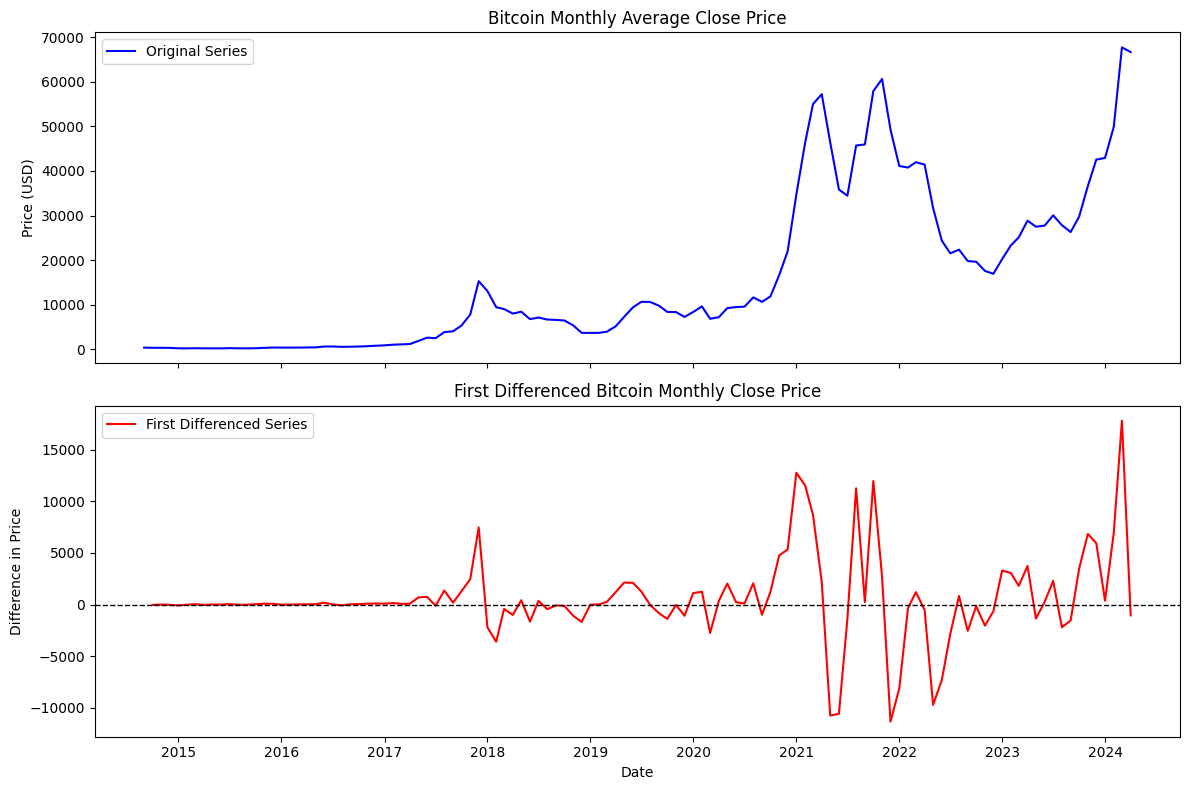

In [168]:
# Plot the original and transformed series
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Original series
ax[0].plot(data.index, data['Average_Close'], label="Original Series", color='blue')
ax[0].set_title("Bitcoin Monthly Average Close Price")
ax[0].set_ylabel("Price (USD)")
ax[0].legend()

# Transformed (First Differenced) series
ax[1].plot(data.index, data['first_diff'], label="First Differenced Series", color='red')
ax[1].set_title("First Differenced Bitcoin Monthly Close Price")
ax[1].set_ylabel("Difference in Price")
ax[1].axhline(0, linestyle="dashed", color='black', linewidth=1)
ax[1].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()

In [169]:
# Apply ADF test on the first differenced series (drop NaN values)
adf_test_diff = adfuller(data['first_diff'].dropna())

# Extract results
adf_statistic = adf_test_diff[0]
p_value = adf_test_diff[1]
critical_values = adf_test_diff[4]

# Print results
print("Augmented Dickey-Fuller Test on First Differenced Series:")
print(f"ADF Statistic: {adf_statistic}")
print(f"P-Value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Interpretation
if p_value < 0.05:
    print("\nConclusion: The first differenced series is likely stationary (reject null hypothesis).")
else:
    print("\nConclusion: The first differenced series is likely non-stationary (fail to reject null hypothesis).")

Augmented Dickey-Fuller Test on First Differenced Series:
ADF Statistic: -7.025524683182111
P-Value: 6.379404369062368e-10
Critical Values:
   1%: -3.489589552580676
   5%: -2.887477210140433
   10%: -2.580604145195395

Conclusion: The first differenced series is likely stationary (reject null hypothesis).


In [170]:
# Apply log transformation
data['log_Average_Close'] = np.log(data['Average_Close'])

# Apply first differencing after log transformation
data['log_first_diff'] = data['log_Average_Close'].diff().round(2)
data.head()

,Average_Close,first_diff,log_Average_Close,log_first_diff
Year_Month,,,,
2014-09-01,407.18,NaN,6.009255,NaN
2014-10-01,364.15,-43.03,5.897566,-0.11
2014-11-01,366.10,1.95,5.902907,0.01
2014-12-01,341.27,-24.83,5.832674,-0.07
2015-01-01,248.78,-92.49,5.516569,-0.32


In [171]:
# Apply ADF test on the log-transformed first differenced series
adf_test_log_diff = adfuller(data['log_first_diff'].dropna())  # Drop NaN values from first differencing

# Extract results
adf_statistic = adf_test_log_diff[0]
p_value = adf_test_log_diff[1]
critical_values = adf_test_log_diff[4]

# Print results
print("Augmented Dickey-Fuller Test on Log-Transformed First Differenced Series:")
print(f"ADF Statistic: {adf_statistic}")
print(f"P-Value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Interpretation
if p_value < 0.05:
    print("\nConclusion: The log-transformed first differenced series is stationary (reject null hypothesis).")
else:
    print("\nConclusion: The log-transformed first differenced series is non-stationary (fail to reject null hypothesis).")

Augmented Dickey-Fuller Test on Log-Transformed First Differenced Series:
ADF Statistic: -7.181129230766409
P-Value: 2.6481506175602916e-10
Critical Values:
   1%: -3.489057523907491
   5%: -2.887246327182993
   10%: -2.5804808802708528

Conclusion: The log-transformed first differenced series is stationary (reject null hypothesis).


In [172]:
# Define the range of p, d, q values to test
p = range(0, 3)  # AR terms
d = [1]  # Differencing order is fixed at 1 (already differenced)
q = range(0, 3)  # MA terms

# Generate all possible combinations of (p, d, q)
pdq_combinations = list(itertools.product(p, d, q))

# Data for comparison
aic_results = []

In [173]:
#Fit ARIMA models for different (p, d, q) values and store AIC values using first_diff
for param in pdq_combinations:
    try:
        model = sm.tsa.ARIMA(data['first_diff'].dropna(), order=param)
        result = model.fit()
        aic_results.append((param, result.aic))
        print(f"ARIMA{param} - AIC: {result.aic}")
    except Exception as e:
        print(f"ARIMA{param} - Error: {e}")

# Find the best model based on lowest AIC
best_model_params = min(aic_results, key=lambda x: x[1])[0]  # Get the (p,d,q) with lowest AIC

# Fit the best ARIMA model with seasonal_order=(0,0,0,12)
best_arima_model = sm.tsa.ARIMA(data['first_diff'].dropna(), order=best_model_params)
best_arima_result = best_arima_model.fit()

# Display the best ARIMA model summary
print("\nBest ARIMA Model Selected:")
print(f"ARIMA{best_model_params} - AIC: {best_arima_result.aic}\n")
print(best_arima_result.summary())

ARIMA(0, 1, 0) - AIC: 2236.757541161618
ARIMA(0, 1, 1) - AIC: 2225.800118981367


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(0, 1, 2) - AIC: 2200.642690797759
ARIMA(1, 1, 0) - AIC: 2236.418289587065
ARIMA(1, 1, 1) - AIC: 2206.027910687825


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(1, 1, 2) - AIC: 2202.430624823641
ARIMA(2, 1, 0) - AIC: 2226.428350400614
ARIMA(2, 1, 1) - AIC: 2205.9938596503384


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(2, 1, 2) - AIC: 2204.1196425261296

Best ARIMA Model Selected:
ARIMA(0, 1, 2) - AIC: 2200.642690797759

                               SARIMAX Results                                
Dep. Variable:             first_diff   No. Observations:                  115
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1097.321
Date:                Sat, 01 Mar 2025   AIC                           2200.643
Time:                        01:29:21   BIC                           2208.851
Sample:                    10-01-2014   HQIC                          2203.974
                         - 04-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4700      0.085     -5.532      0.000      -0.637      -0.304
ma.L2         -0.5299

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [174]:
#Fit ARIMA models for different (p, d, q) values and store AIC values using log_first_diff
for param in pdq_combinations:
    try:
        model = sm.tsa.ARIMA(data['log_first_diff'].dropna(), order=param)
        result = model.fit()
        aic_results.append((param, result.aic))
        print(f"ARIMA{param} - AIC: {result.aic}")
    except Exception as e:
        print(f"ARIMA{param} - Error: {e}")

# Find the best model based on lowest AIC
best_model_params = min(aic_results, key=lambda x: x[1])[0]  # Get the (p,d,q) with lowest AIC

# Fit the best ARIMA model with seasonal_order=(0,0,0,12)
best_arima_model = sm.tsa.ARIMA(data['log_first_diff'].dropna(), order=best_model_params)
best_arima_result = best_arima_model.fit()

# Display the best ARIMA model summary
print("\nBest ARIMA Model Selected:")
print(f"ARIMA{best_model_params} - AIC: {best_arima_result.aic}\n")
print(best_arima_result.summary())

ARIMA(0, 1, 0) - AIC: -37.38897392384299


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(0, 1, 1) - AIC: -60.64936598435153
ARIMA(0, 1, 2) - AIC: -71.95681233346747
ARIMA(1, 1, 0) - AIC: -44.47484127320182


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(1, 1, 1) - AIC: -71.88410611762126


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2) - AIC: -70.3491331230762
ARIMA(2, 1, 0) - AIC: -55.509924895881234


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(2, 1, 1) - AIC: -70.09307853836957


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2) - AIC: -69.88267054051998

Best ARIMA Model Selected:
ARIMA(0, 1, 2) - AIC: -71.95681233346747



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         log_first_diff   No. Observations:                  115
Model:                 ARIMA(0, 1, 2)   Log Likelihood                  38.978
Date:                Sat, 01 Mar 2025   AIC                            -71.957
Time:                        01:29:23   BIC                            -63.748
Sample:                    10-01-2014   HQIC                           -68.625
                         - 04-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6052     14.892     -0.041      0.968     -29.792      28.582
ma.L2         -0.3947      5.906     -0.067      0.947     -11.970      11.180
sigma2         0.0285      0.423      0.067      0.9

AIC VALUE of -71.967 using log_first_diff performs better than AIC VALUE of 2200.643 using first_diff. So we will proceed with using log_first_diff in our subsequent models.

In [175]:
# Fit a Seasonal ARIMA (SARIMA) model with seasonal order (1,1,1,12)
sarima_model = sm.tsa.SARIMAX(data['log_first_diff'].dropna(),
                              order=(0, 1, 2),  # Best ARIMA order
                              seasonal_order=(1, 1, 1, 12),  # Adding seasonality
                              enforce_stationarity=False,
                              enforce_invertibility=False)

# Fit the model
sarima_result = sarima_model.fit()

# Display the SARIMA model summary
print("\n### SARIMA Model Summary ###")
print(sarima_result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



### SARIMA Model Summary ###
                                      SARIMAX Results                                       
Dep. Variable:                       log_first_diff   No. Observations:                  115
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 12)   Log Likelihood                  13.269
Date:                              Sat, 01 Mar 2025   AIC                            -16.538
Time:                                      01:29:24   BIC                             -4.208
Sample:                                  10-01-2014   HQIC                           -11.573
                                       - 04-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6006    451.907     -0.001      0.999    -886.322  

In [176]:
# Define possible configurations for ETS model
error_types = ["add", "mul"]  # Error types: Additive, Multiplicative
trend_types = ["add", "mul", "additive_damped", None]  # Trend options
seasonal_types = ["add", "mul", None]  # Seasonality options

# Store AIC results
ets_results = []

# Iterate over all possible combinations of error, trend, and seasonality
for error in error_types:
    for trend in trend_types:
        for seasonal in seasonal_types:
            try:
                # Fit ETS model
                ets_model = ExponentialSmoothing(data['Average_Close'],
                                                 trend=trend if trend != "additive_damped" else "add",
                                                 damped_trend=True if trend == "additive_damped" else False,
                                                 seasonal=seasonal,
                                                 seasonal_periods=12 if seasonal else None)
                ets_result = ets_model.fit()

                # Store the results
                ets_results.append((error, trend, seasonal, ets_result.aic))
                print(f"ETS({error}, {trend}, {seasonal}) - AIC: {ets_result.aic}")
            except Exception as e:
                print(f"ETS({error}, {trend}, {seasonal}) - Error: {e}")

# Convert results to a DataFrame and find the best AIC
ets_results_df = pd.DataFrame(ets_results, columns=["Error", "Trend", "Seasonality", "AIC"]).sort_values(by="AIC")

# Display the best model based on AIC
best_ets_model = ets_results_df.iloc[0]
print(f"\nBest ETS Model: ETS({best_ets_model['Error']}, {best_ets_model['Trend']}, {best_ets_model['Seasonality']}) - AIC: {best_ets_model['AIC']}")

ETS(add, add, add) - AIC: 1963.5017100776067
ETS(add, add, mul) - AIC: 2145.6988846648396
ETS(add, add, None) - AIC: 1936.7730661295054


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmode

ETS(add, mul, add) - AIC: 1964.353261050974


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: Va

ETS(add, mul, mul) - AIC: 2008.4774935848916
ETS(add, mul, None) - AIC: 1947.0003832846946
ETS(add, additive_damped, add) - AIC: 1964.7633062227364
ETS(add, additive_damped, mul) - AIC: 2008.0248987634204
ETS(add, additive_damped, None) - AIC: 1938.0125271148777
ETS(add, None, add) - AIC: 1960.6178742494405


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: Va

ETS(add, None, mul) - AIC: 2002.0453164584583
ETS(add, None, None) - AIC: 1934.1872144752124
ETS(mul, add, add) - AIC: 1963.5017100776067
ETS(mul, add, mul) - AIC: 2145.6988846648396
ETS(mul, add, None) - AIC: 1936.7730661295054


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ETS(mul, mul, add) - AIC: 1964.353261050974
ETS(mul, mul, mul) - AIC: 2008.4774935848916


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: Va

ETS(mul, mul, None) - AIC: 1947.0003832846946
ETS(mul, additive_damped, add) - AIC: 1964.7633062227364
ETS(mul, additive_damped, mul) - AIC: 2008.0248987634204
ETS(mul, additive_damped, None) - AIC: 1938.0125271148777
ETS(mul, None, add) - AIC: 1960.6178742494405
ETS(mul, None, mul) - AIC: 2002.0453164584583
ETS(mul, None, None) - AIC: 1934.1872144752124

Best ETS Model: ETS(add, None, None) - AIC: 1934.1872144752124


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: Va

In [177]:
#splitting data into test and train
train_size=int(len(data)*0.80)
X_train,X_test=data[0:train_size],data[train_size:len(data)]

In [178]:
X_train.shape

(92, 4)

In [179]:
X_test.shape

(24, 4)

In [180]:
# Define start and end indices for training predictions
start_index_train = 0
end_index_train = len(X_train) - 1

# Generate predictions for the training period
train_prediction = best_arima_result.predict(start=start_index_train, end=end_index_train)
# Convert predictions back to original scale (since we used log differencing)
train_prediction_original_scale = np.exp(data['log_Average_Close'].iloc[0] + train_prediction.cumsum())
train_prediction_original_scale.head()

,predicted_mean
2014-10-01,407.180000
2014-11-01,364.765744
2014-12-01,357.943488
2015-01-01,328.882777
2015-02-01,265.359987


In [181]:
# Define start and end indices for testing predictions
start_index_test = len(X_train)
end_index_test = len(data) - 1

# Generate predictions for the testing period
test_prediction = best_arima_result.predict(start=start_index_test, end=end_index_test)

# Convert predictions back to original scale (since we used log differencing)
test_prediction_original_scale = np.exp(data['log_Average_Close'].iloc[len(X_train)] + test_prediction.cumsum())
test_prediction_original_scale.head()

,predicted_mean
2022-06-01,29526.032066
2022-07-01,28627.440410
2022-08-01,28819.852634
2022-09-01,30449.034077
2022-10-01,29581.464995


<Axes: xlabel='Year_Month'>

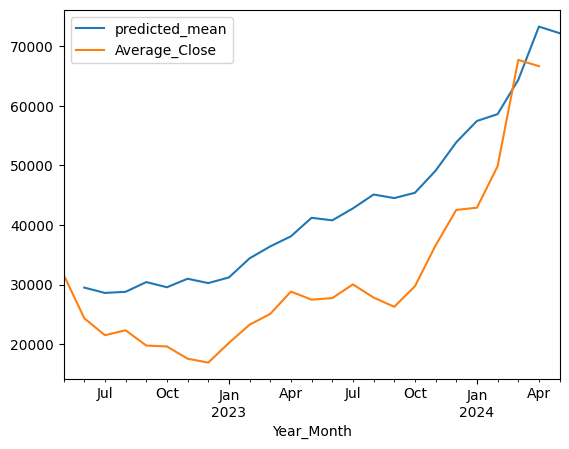

In [182]:
#visualizing predicted_mean and avearge_close
test = data.iloc[train_size:]['Average_Close']
test_prediction_original_scale.plot(legend=True)
test.plot(legend=True)

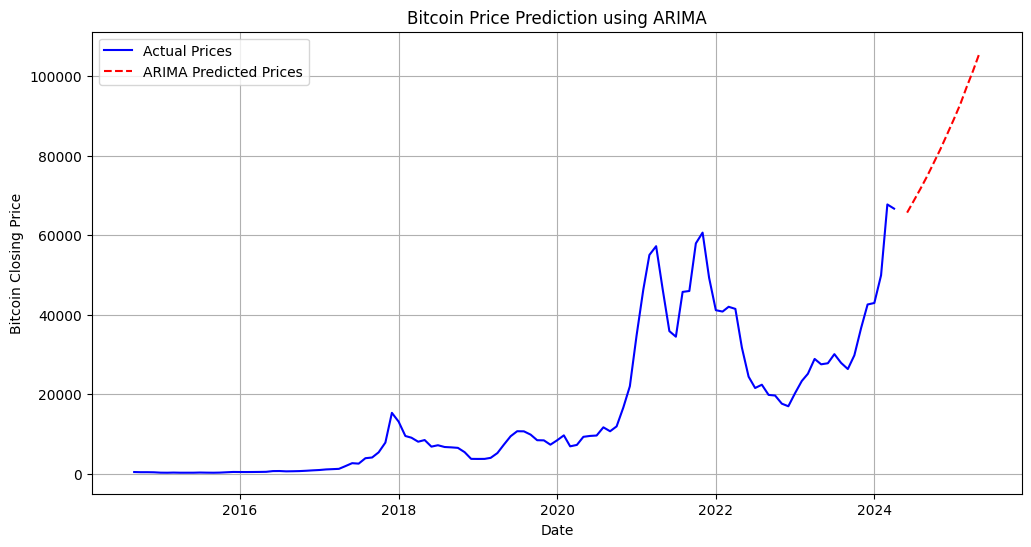

In [183]:
# Generate forecasts using the best ARIMA model
forecast_steps = 12  # Predict next 12 months
arima_forecast = best_arima_result.forecast(steps=forecast_steps)

# Create a datetime index for the forecast
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='ME')[1:]

# Convert forecast back to original scale (since we used log differencing)
arima_forecast_original_scale = np.exp(data['log_Average_Close'].iloc[-1] + arima_forecast.cumsum())

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Average_Close'], label="Actual Prices", color='blue')
plt.plot(forecast_index, arima_forecast_original_scale, label="ARIMA Predicted Prices", color='red', linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Bitcoin Closing Price")
plt.title("Bitcoin Price Prediction using ARIMA")
plt.grid(True)
plt.legend()
plt.show()

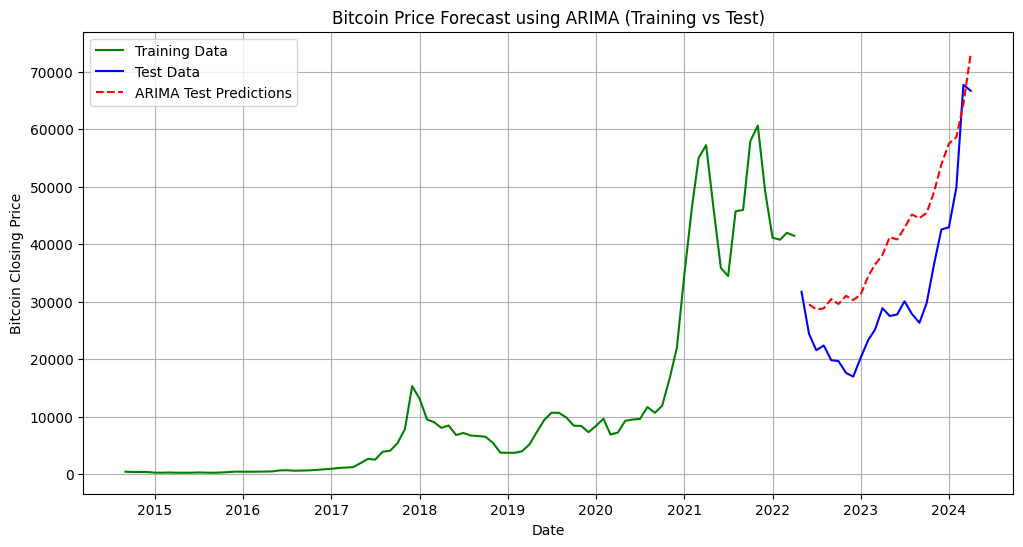

In [184]:
# Ensure predictions and actual values have matching indices
valid_test_indices = test.index.intersection(test_prediction_original_scale.index)

plt.figure(figsize=(12, 6))

# Plot training data using the original dataframe index
plt.plot(data.index[:train_size], data["Average_Close"][:train_size], label="Training Data", color='green')

# Plot test data using the original dataframe index
plt.plot(data.index[train_size:], data["Average_Close"][train_size:], label="Test Data", color='blue')

# Plot ARIMA test predictions with aligned indices
plt.plot(valid_test_indices, test_prediction_original_scale.loc[valid_test_indices],
         label="ARIMA Test Predictions", color='red', linestyle="dashed")

# Formatting plot
plt.xlabel("Date")
plt.ylabel("Bitcoin Closing Price")
plt.title("Bitcoin Price Forecast using ARIMA (Training vs Test)")
plt.legend(loc="upper left")
plt.grid(True)
# Show the plot
plt.show()

In [186]:
# Extract test data from full dataset
test = data.iloc[train_size:]

# Ensure predictions and actual values have matching indices
valid_test_indices = test.index.intersection(test_prediction_original_scale.index)

# Compute Mean Absolute Error (MAE) only on matching data points
mae = mean_absolute_error(test.loc[valid_test_indices, "Average_Close"],
                          test_prediction_original_scale.loc[valid_test_indices])

print(f"Mean Absolute Error (MAE): {mae:.2f}")
# Compute Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100


mape = mean_absolute_percentage_error(test.loc[valid_test_indices, "Average_Close"],
                                     test_prediction_original_scale.loc[valid_test_indices])

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 11151.99
Mean Absolute Percentage Error (MAPE): 42.24%


In [185]:
# Define the forecast period (May 2024)
forecast_date = datetime(2024, 5, 1)

# Calculate the number of steps needed to reach May 2024
last_date_in_data = data.index[-1]
steps = (forecast_date.year - last_date_in_data.year) * 12 + (forecast_date.month - last_date_in_data.month)

# Generate the forecast
forecast = best_arima_result.forecast(steps=steps)

# Convert the forecast back to the original scale
forecast_original_scale = np.exp(data['log_Average_Close'].iloc[-1] + forecast.cumsum())

# Get the predicted value for May 2024
may_2024_prediction = forecast_original_scale.iloc[-1]

print(f"Predicted average closing price for May 2024: {may_2024_prediction}")

Predicted average closing price for May 2024: 65644.84063708459


In [187]:
# Select only the 'Average_Close' column
data_lstm = data[['Average_Close']].values  # Ensure correct data format

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_lstm)

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):  # Ensure no index error
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # Use past 12 months to predict next
X, y = create_sequences(data_scaled, seq_length)

# Split into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1, shuffle=False)

# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Inverse transform predictions to original scale
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_actual, test_pred)
mae = mean_absolute_error(y_test_actual, test_pred)
print(f"Test Mean Squared Error: {mse:.2f}")
print(f"Test Mean Absolute Error: {mae:.2f}")
# Compute Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

mape = mean_absolute_percentage_error(y_test_actual, test_pred)
print(f"Test Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.0226 - val_loss: 0.0684
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0225 - val_loss: 0.0506
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0240 - val_loss: 0.0667
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0183 - val_loss: 0.0802
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0153 - val_loss: 0.0665
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0133 - val_loss: 0.0536
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0132 - val_loss: 0.0513
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0134 - val_loss: 0.0557
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0127 - val_loss: 0.0592
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0132 - val_loss: 0.0583
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0120 - val_loss: 0.0559
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0118 - val_loss: 0.0549
Epoch 13/50

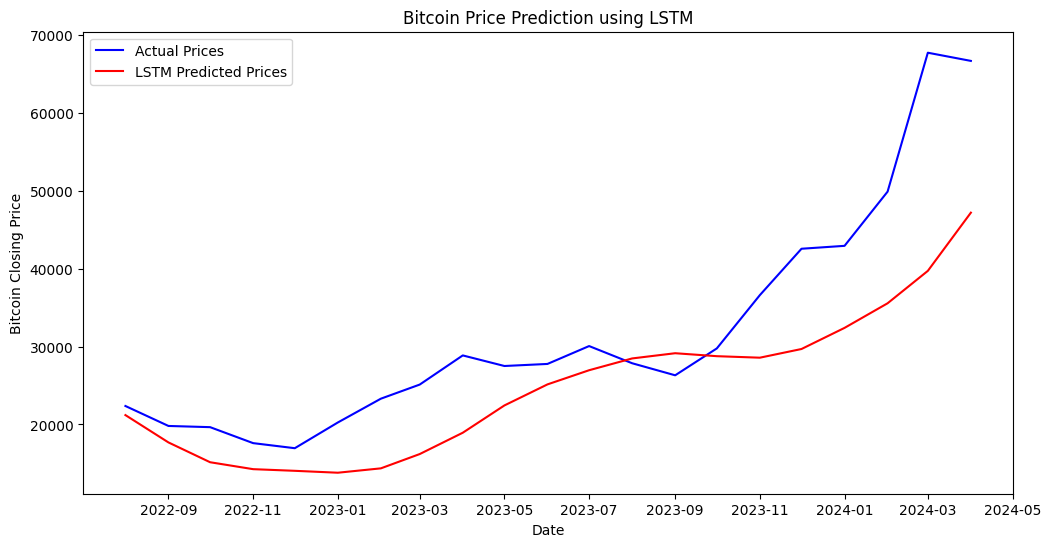

In [188]:
# Retrieve actual dates for plotting
actual_dates = data.index[-len(y_test_actual):]
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_dates, y_test_actual, label="Actual Prices", color='blue')
plt.plot(actual_dates, test_pred, label="LSTM Predicted Prices", color='red')
plt.xlabel("Date")
plt.ylabel("Bitcoin Closing Price")
plt.title("Bitcoin Price Prediction using LSTM")
plt.legend()
plt.show()

In [189]:
# Compute number of parameters (trainable weights)
k = np.sum([np.prod(v.shape) for v in model.trainable_variables])

# Compute Mean Squared Error (MSE) on test data
mse = mean_squared_error(y_test_actual, test_pred)

# Number of observations
n = len(y_test_actual)

# Compute AIC for LSTM
aic_lstm = n * np.log(mse) + 2 * k
print(f"LSTM AIC (Approximated): {aic_lstm}")

LSTM AIC (Approximated): 144988.89155699007


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


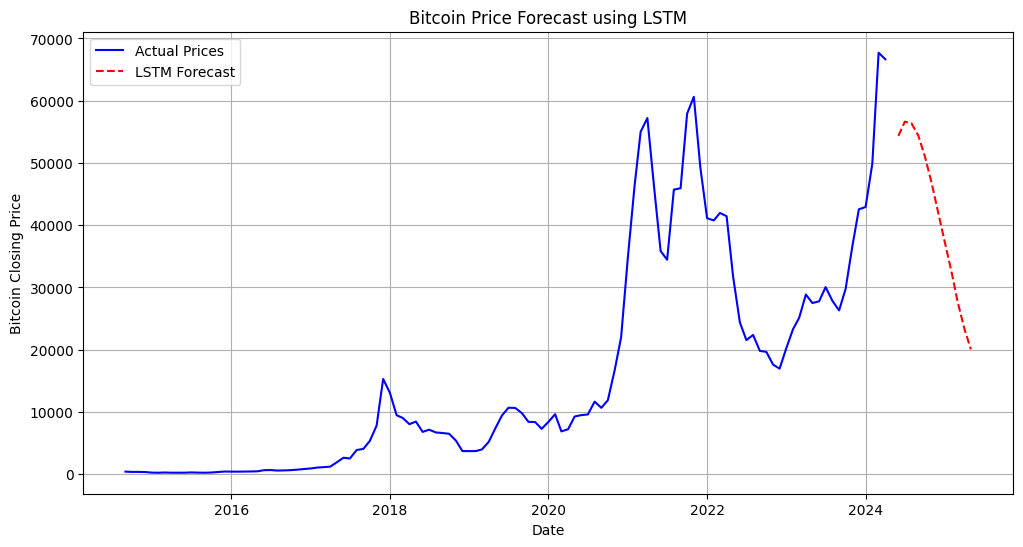

In [190]:
# Generate forecasts using the trained LSTM model
# Select the last `seq_length` data points for input
last_sequence = data_scaled[-seq_length:]  # Last 12 months
last_sequence = np.reshape(last_sequence, (1, seq_length, 1))  # Reshape for LSTM input

# Predict future values for the next 12 months
future_predictions = []
for _ in range(12):  # Predict next 12 months
    predicted_value = model.predict(last_sequence)  # Predict next value
    future_predictions.append(predicted_value[0, 0])  # Store the predicted value

    # Update sequence with the new predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift sequence left
    last_sequence[0, -1, 0] = predicted_value.item()  # Convert array to scalar

# Inverse transform predictions to original scale
future_predictions_original_scale = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates
future_dates = pd.date_range(start=data.index[-1], periods=13, freq='ME')[1:]

# Create a DataFrame to store future predictions
future_forecast_df = pd.DataFrame({
    "Date": future_dates,
    "LSTM_Predicted_Price": future_predictions_original_scale.flatten()
})

# Plot the actual prices and future predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Average_Close"], label="Actual Prices", color='blue')
plt.plot(future_forecast_df["Date"], future_forecast_df["LSTM_Predicted_Price"], label="LSTM Forecast", color='red', linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Bitcoin Closing Price")
plt.title("Bitcoin Price Forecast using LSTM")
plt.legend()
plt.grid(True)
plt.show()

In [191]:
# using LSTM model to predict average closing price for May 2024
# Create the input sequence for May 2024 prediction
last_sequence = data_scaled[-seq_length:]
last_sequence = np.reshape(last_sequence, (1, seq_length, 1))

# Predict the closing price for May 2024
may_2024_prediction_scaled = model.predict(last_sequence)

# Inverse transform the prediction to the original scale
may_2024_prediction = scaler.inverse_transform(may_2024_prediction_scaled)

# Print the prediction
print(f"Predicted average closing price for May 2024 using LSTM: {may_2024_prediction[0,0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted average closing price for May 2024 using LSTM: 54341.375


**Ground Truth**

In [192]:
#importing the data
from google.colab import files
uploaded = files.upload()

Saving Filtered_Bitcoin_Close_May_2024.csv to Filtered_Bitcoin_Close_May_2024 (4).csv


In [193]:
#reading in the data (ground_truth May 2024)
data_may= pd.read_csv('Filtered_Bitcoin_Close_May_2024.csv')
data_may.head()

,Date,Close
0,2024-05-01,58254.011719
1,2024-05-02,59123.433594
2,2024-05-03,62889.835938
3,2024-05-04,63891.472656
4,2024-05-05,64031.132813


In [194]:
#ground_truth/actual average closing price for may 2024
# Convert the 'Date' column to datetime objects if it's not already
data_may['Date'] = pd.to_datetime(data_may['Date'])
data_may = data_may.set_index('Date')

# Calculate the average closing price for May 2024
average_closing_price_may_2024 = data_may['Close'].mean()

print(f"Actual Average closing price for May 2024: {average_closing_price_may_2024}")

Actual Average closing price for May 2024: 65266.3172885484


Arima Model has MAE value of 11151.99, Mean Absolute Percentage Error (MAPE): 42.24% and it predicted the average closing price for May 2024 as 65644.84

LSTM model has MAE value of 7462.24, Mean Absolute Percentage Error (MAPE): 21.21% and it predicted the average closing price for May 2024 as 54341.37

Arima Model has a closer prediction to Actual May 2024 average closing price. ARIMA AIC: -71.956

LSTM model has a better MAE metric but has poor forecasting performance which is evident in the Bitcoin Price Forecast visualization using LSTM. LSTM AIC (Approximated): 144975.23

Arima Model has a better forecasting performance.